<a href="https://colab.research.google.com/github/itsPrachi001/starttech_academy/blob/master/task_4_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

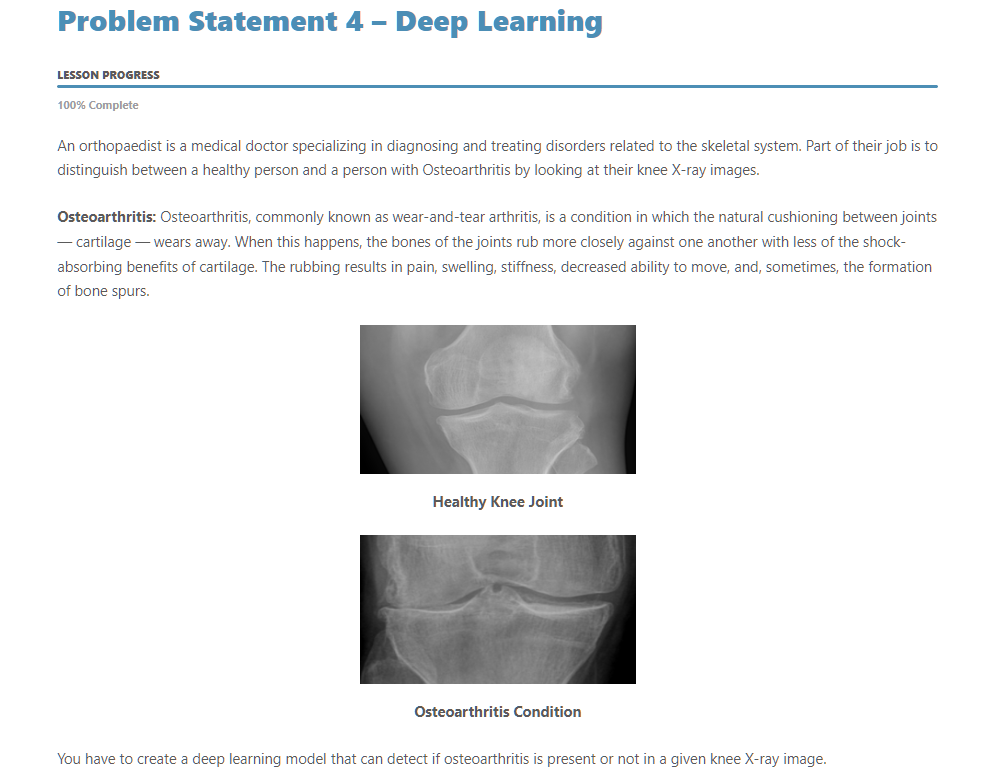

In [ ]:
from glob import glob
import os
import random
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model, Model, Sequential
import cv2,os
from google.colab import drive
drive.mount('/content/drive')
data_path='/content/drive/MyDrive/Osteoarthritis_Assignment_dataset'

Mounted at /content/drive


In [ ]:
IMG_height = 224
IMG_width = 224
val_path=r'/content/drive/MyDrive/Osteoarthritis_Assignment_dataset/Valid'
test_path=r'/content/drive/MyDrive/Osteoarthritis_Assignment_dataset/test'
train_path=r'/content/drive/MyDrive/Osteoarthritis_Assignment_dataset/train'

In [ ]:
classes = os.listdir(train_path)

# Counting total number of images for training and valdation
num_train = len(glob(train_path + '/*/*'))
num_val = len(glob(val_path + '/*/*'))
print('Classes : ', classes)
print(f'Number of training images : {num_train}\nNumber of validation images : {num_val}')

Classes :  ['Osteoarthritis', 'Normal']
Number of training images : 2350
Number of validation images : 641


In [ ]:
# Loading images from image paths
def parse_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [IMG_height, IMG_width])
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [ ]:
def make_dataset(path, batch_size):
    
    # Collecting all filepath in a directory
    filenames = glob(path + '/*/*')
    # Shuffling the dataset
    random.shuffle(filenames)
    # Extraction labels from fil paths(as numbers Normal:0, Osteoarthritis:1)
    labels = [classes.index(name.split(os.path.sep)[-2]) for name in filenames]

    # Creating instance of tf.data.dataset from filenames
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    # loading files
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    images_ds = tf.data.Dataset.zip((images_ds, labels_ds))
    images_ds = images_ds.shuffle(buffer_size=100)
    images_ds = images_ds.batch(batch_size)
    images_ds = images_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return images_ds

In [ ]:
%%time
ds_train = make_dataset(train_path, 32)
ds_val = make_dataset(train_path, 32)
ds_test = make_dataset(train_path, 128)


CPU times: user 342 ms, sys: 25.9 ms, total: 368 ms
Wall time: 721 ms


In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=5,
        verbose=1,
    )
]

In [ ]:
def build_model_A():
    batch_size = 32
    num_classes = 2

    i = Input(shape=(224, 224, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)

    # Hidden layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)

    # last hidden layer i.e.. output layer
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(i, x)

    # model description
    model.summary()

    model.compile(optimizer=keras.optimizers.Adam(3e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model = build_model_A()
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0     

In [ ]:
# training model
model.fit(ds_train, epochs=20, steps_per_epoch=math.ceil(num_train/32), 
          verbose=1, callbacks=callbacks, validation_data=ds_val,
         validation_steps=math.ceil(num_val/32))

Epoch 1/20
74/74 [==============================] - 2555s 35s/step - loss: 2.4237 - accuracy: 0.7353 - val_loss: 38.2316 - val_accuracy: 0.3452
Epoch 2/20
74/74 [==============================] - 985s 13s/step - loss: 0.3964 - accuracy: 0.8200 - val_loss: 48.3506 - val_accuracy: 0.3393
Epoch 3/20
74/74 [==============================] - 981s 13s/step - loss: 0.2811 - accuracy: 0.8809 - val_loss: 36.1175 - val_accuracy: 0.3467
Epoch 4/20
74/74 [==============================] - 981s 13s/step - loss: 0.2137 - accuracy: 0.9089 - val_loss: 27.1861 - val_accuracy: 0.3363
Epoch 5/20
74/74 [==============================] - 984s 13s/step - loss: 0.2234 - accuracy: 0.9123 - val_loss: 15.3418 - val_accuracy: 0.3676
Epoch 6/20
74/74 [==============================] - 992s 13s/step - loss: 0.1647 - accuracy: 0.9311 - val_loss: 4.4945 - val_accuracy: 0.6726
Epoch 7/20
74/74 [==============================] - 1005s 14s/step - loss: 0.1025 - accuracy: 0.9591 - val_loss: 4.5634 - val_accuracy: 0.7173

In [ ]:
model.save('model.h5')

In [ ]:
# evaluating model
model.evaluate(ds_test)

In [ ]:
# saving model
model.save('Osteoarthritis_Classifier.model', save_format='h5')